In [2]:
import os 
import random
import numpy as np
import pandas as pd
import importlib as imp
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
import warnings
warnings.simplefilter('ignore')
pd.options.display.max_columns = 100

**article**
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.457.8027&rep=rep1&type=pdf

In [155]:
from utils import tools, visualize, common
bname = 'benchmarks/B/B-n35-k5.vrp'
problem = tools.get_problem(bname)

n_trucks -> 5
optimal -> 955
capacity -> 100
n_locations -> 35
depot_i -> 0
demands -> [0.0, 12.0, 3.0, 2.0, 13.0, 17.0, 12.0, 1.0, 26.0, 13.0, 15.0, 20.0, 20.0, 3.0, 3.0, 12.0, 25.0, 2.0, 15.0, 24.0, 2.0, 7.0, 15.0, 2.0, 13.0, 9.0, 12.0, 26.0, 17.0, 26.0, 9.0, 14.0, 9.0, 25.0, 13.0]


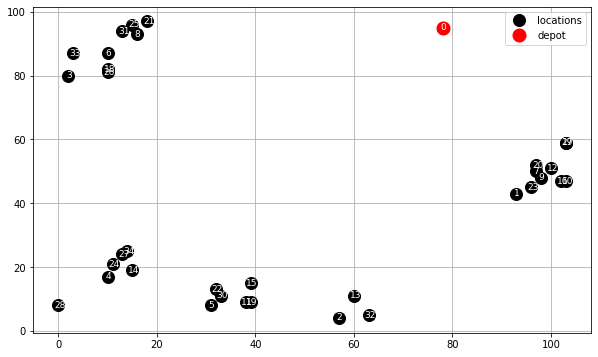

In [156]:
tools     = imp.reload(tools)
visualize = imp.reload(visualize)
common    = imp.reload(common)

visualize.visualize_problem(problem)
for k, v in problem.items():
    if k !='locations' and k !='dists':
        print(k,"->", v)
plt.savefig('output/images/problem'+bname[-10:]+'.png', dpi=400)

In [157]:
common   = imp.reload(common)
solution = common.generate_solution(problem, alpha=0.01, betta=50, verbose=False)
print('Is feasible? {}'.format(common.check_solution(problem, solution, verbose=True)))
sol_cost = common.compute_solution(problem, solution)
print('Solution cost:', sol_cost)
solution

Is feasible? True
Solution cost: 1561.0216


array([ 0, 32, 28, 30, 14, 11, 34, 19,  2, 20,  0, 33, 26, 21, 25, 27, 18,
        3,  0,  7, 12,  9, 16,  1, 10, 15, 17,  0, 29, 22, 24, 13,  4,  5,
       23,  0,  6,  8, 31,  0])

In [166]:
from algorithm import bee_colony, local_search, neighbor_operator
bee_colony = imp.reload(bee_colony)
local_search = imp.reload(local_search)
neighbor_operator = imp.reload(neighbor_operator)
common = imp.reload(common)


ABC = bee_colony.BeeColony(problem)
ABC.set_params(    
                   n_epoch=200,
                   n_initials=30,
                   n_onlookers=20,
                   search_limit=50
              )
%time abc_solution = ABC.solve(alpha=0.1, delta=0.01, gen_alpha=0.01, gen_betta=25)


Tries:  17
Wall time: 22.4 s


In [167]:
new_cost = common.compute_solution(problem, abc_solution)
print('Is feasible?',common.check_solution(problem, abc_solution, verbose=True))
print('Is capacity?',common.check_capacity_criteria(problem, abc_solution, verbose=False))
print('ABC cost: {}'.format(new_cost))
print('Optimal cost: {}'.format(problem['optimal']))

Is feasible? True
Is capacity? True
ABC cost: 992.5340576171875
Optimal cost: 955


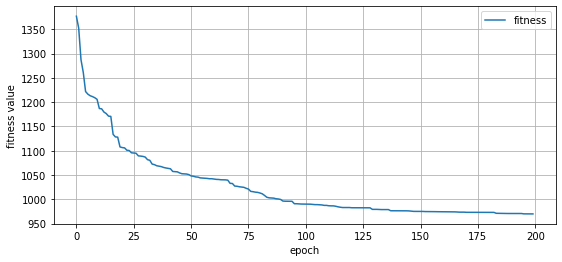

In [168]:
visualize = imp.reload(visualize)
visualize.visualize_fitness(ABC.history)
plt.savefig('output/images/history_'+bname[-10:]+'.png', dpi=400)

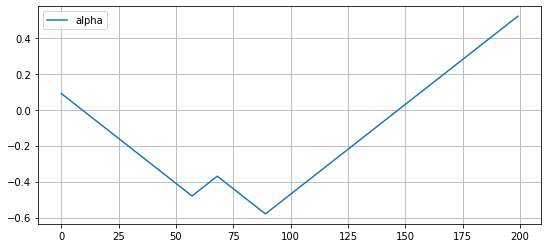

In [169]:
plt.figure(figsize=(9,4))
plt.plot(ABC.history_alpha, label='alpha')
plt.legend()
plt.grid()
plt.show()

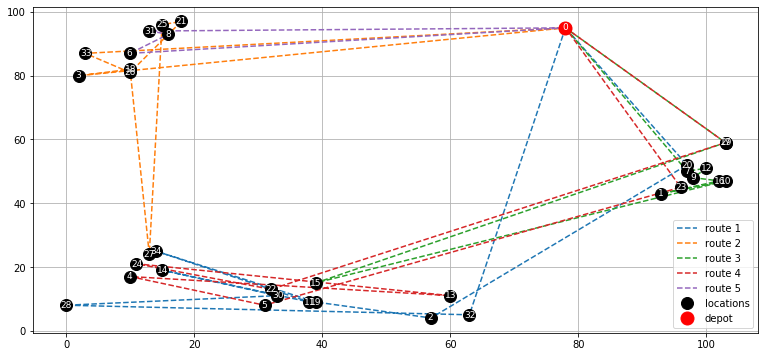

In [170]:
visualize.visualize_problem(problem, solution, figsize=(13,6))
plt.savefig('output/images/beforeABC_'+bname[-10:]+'.png', dpi=400)

Route #1 [ 6 33  3 27 34]
Route #2 [18 26  8 31 25 21]
Route #3 [20  7  9 23  1 13 32  2 11 30 22]
Route #4 [14 24  4 28  5 19 15]
Route #5 [17 29 10 16 12]


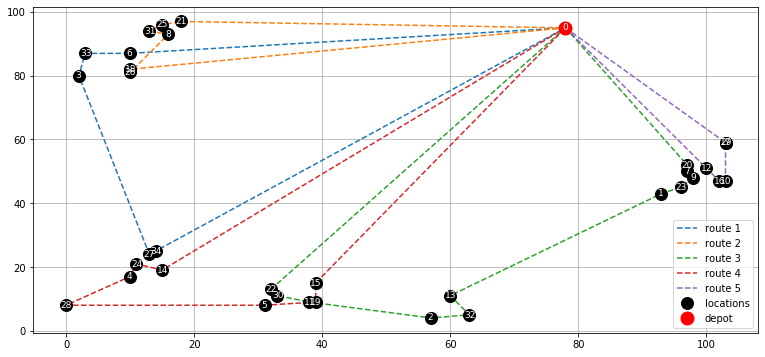

In [171]:
visualize.visualize_problem(problem, abc_solution, figsize=(13,6))
depots = list(filter(lambda i: abc_solution[i]==0, range(len(abc_solution))))
for i, route in  enumerate(common.get_routes(abc_solution)):
    print('Route #{}'.format(i+1),route)
# len(abc_solution), len(np.unique(abc_solution))
plt.savefig('output/images/afterABC_'+bname[-10:]+'.png', dpi=400)

## B-benchmarks

In [ ]:
%%time
import glob
from datetime import datetime
tools     = imp.reload(tools)
bee_colony = imp.reload(bee_colony)
local_search = imp.reload(local_search)
common = imp.reload(common)
neighbor_operator = imp.reload(neighbor_operator)



b_benchmarks = glob.glob('benchmarks/B/*')

info_dct = dict(benchmark=[],
                n_locations=[],
                n_trucks=[],
                capacity=[],
                optimal_cost=[],
                ABC_cost=[],
                ABC_time=[],
                is_feasible=[],
                error=[],
                abc_solution=[],
                abc_epochs=[],
                abc_employers=[],
                abc_onlookers=[],
                abc_search_limit=[])

for itr, benchmark in enumerate(b_benchmarks[:]):
    problem = tools.get_problem(benchmark)
    
    bench_name = benchmark[benchmark.index("\\")+1:]
    print('#{}'.format(itr), bench_name,'...')

    ABC = bee_colony.BeeColony(problem)
    ABC.set_params(    
                       n_epoch=300,
                       n_initials=problem['n_locations'],
                       n_onlookers=5,
                       search_limit=problem['n_locations']
                  )
    start_time = datetime.now()
    alpha = problem['n_locations'] / 100
    delta = 0.01
    gen_alpha = 0.5
    gen_betta = problem['n_locations']
    abc_solution = ABC.solve(alpha=alpha, delta=delta, gen_betta=gen_betta)
    end_time = (datetime.now() - start_time).total_seconds()
    
    abc_cost = common.compute_solution(problem, abc_solution)
    is_feasible = common.check_solution(problem, abc_solution, verbose=True)
    error = (abc_cost - problem['optimal']) / problem['optimal']
    print('epoch:',ABC.n_epoch, 'initials:', ABC.n_initials,'search_limit:', ABC.search_limit)
    

    info_dct['benchmark']    += [bench_name]
    info_dct['n_locations']  += [problem['n_locations']]
    info_dct['n_trucks']     += [problem['n_trucks']]
    info_dct['capacity']     += [problem['capacity']]
    info_dct['optimal_cost'] += [problem['optimal']]
    info_dct['ABC_cost']      += [abc_cost]
    info_dct['ABC_time']      += [end_time]
    info_dct['is_feasible']   += [is_feasible]
    info_dct['error']         += [error]
    info_dct['abc_solution']  += [abc_solution]
    info_dct['abc_epochs']    += [ABC.n_epoch]
    info_dct['abc_employers'] += [ABC.n_initials]
    info_dct['abc_onlookers'] += [ABC.n_onlookers]
    info_dct['abc_search_limit'] += [ABC.search_limit]
    
    print(alpha, delta, gen_betta)
    if not is_feasible:
        print('Does not feasible...')
        break
    
    tools.write_solution(abc_solution, abc_cost, filename='B_test/'+bench_name[:-4]+'.sol')

In [185]:
b_stat = pd.DataFrame.from_dict(info_dct)
columns = ['benchmark', 'n_locations', 'n_trucks', 'capacity', 'optimal_cost', 'ABC_cost', 'ABC_time', 'error', 'is_feasible']
print(b_stat[columns].to_markdown())

|    | benchmark     |   n_locations |   n_trucks |   capacity |   optimal_cost |   ABC_cost |   ABC_time |     error | is_feasible   |
|---:|:--------------|--------------:|-----------:|-----------:|---------------:|-----------:|-----------:|----------:|:--------------|
|  0 | B-n31-k5.vrp  |            31 |          5 |        100 |            672 |    706.569 |    20.9377 | 0.0514423 | True          |
|  1 | B-n34-k5.vrp  |            34 |          5 |        100 |            788 |    808.974 |    23.4713 | 0.0266171 | True          |
|  2 | B-n35-k5.vrp  |            35 |          5 |        100 |            955 |    996.195 |    24.5341 | 0.0431363 | True          |
|  3 | B-n38-k6.vrp  |            38 |          6 |        100 |            805 |    820.224 |    28.2701 | 0.0189118 | True          |
|  4 | B-n39-k5.vrp  |            39 |          5 |        100 |            549 |    567.277 |    26.7929 | 0.0332911 | True          |
|  5 | B-n41-k6.vrp  |            41 |          6 |        100 |            829 |    947.016 |    30.4575 | 0.142359  | True          |
|  6 | B-n43-k6.vrp  |            43 |          6 |        100 |            742 |    777.761 |    33.5126 | 0.0481955 | True          |
|  7 | B-n44-k7.vrp  |            44 |          7 |        100 |            909 |    985.969 |    36.6416 | 0.0846748 | True          |
|  8 | B-n45-k5.vrp  |            45 |          5 |        100 |            751 |    796.818 |    32.5534 | 0.0610096 | True          |
|  9 | B-n45-k6.vrp  |            45 |          6 |        100 |            678 |    768.834 |    37.3276 | 0.133974  | True          |
| 10 | B-n50-k7.vrp  |            50 |          7 |        100 |            741 |    763.865 |    41.6256 | 0.0308568 | True          |
| 11 | B-n50-k8.vrp  |            50 |          8 |        100 |           1312 |   1354.85  |    44.7541 | 0.0326566 | True          |
| 12 | B-n51-k7.vrp  |            51 |          7 |        100 |           1032 |   1124.62  |    42.9064 | 0.0897509 | True          |
| 13 | B-n52-k7.vrp  |            52 |          7 |        100 |            747 |    818.84  |    43.2389 | 0.0961716 | True          |
| 14 | B-n56-k7.vrp  |            56 |          7 |        100 |            707 |    792.316 |    47.4659 | 0.120674  | True          |
| 15 | B-n57-k7.vrp  |            57 |          7 |        100 |           1153 |   1555.21  |    66.0018 | 0.348837  | True          |
| 16 | B-n57-k9.vrp  |            57 |          9 |        100 |           1598 |   1740.66  |    57.6039 | 0.0892725 | True          |
| 17 | B-n63-k10.vrp |            63 |         10 |        100 |           1496 |   1775.97  |    75.6478 | 0.187143  | True          |
| 18 | B-n64-k9.vrp  |            64 |          9 |        100 |            861 |   1082.98  |    75.0857 | 0.257812  | True          |
| 19 | B-n66-k9.vrp  |            66 |          9 |        100 |           1316 |   1611.2   |    82.5796 | 0.224317  | True          |
| 20 | B-n67-k10.vrp |            67 |         10 |        100 |           1032 |   1206.82  |    86.4656 | 0.169402  | True          |
| 21 | B-n68-k9.vrp  |            68 |          9 |        100 |           1272 |   1442.81  |    67.5301 | 0.134288  | True          |
| 22 | B-n78-k10.vrp |            78 |         10 |        100 |           1221 |   1602.17  |    93.2046 | 0.312182  | True          |

## A-benchmarks


In [ ]:
%%time
tools     = imp.reload(tools)
bee_colony = imp.reload(bee_colony)
local_search = imp.reload(local_search)
common = imp.reload(common)
neighbor_operator = imp.reload(neighbor_operator)



b_benchmarks = glob.glob('benchmarks/A/*')

info_dct = dict(benchmark=[],
                n_locations=[],
                n_trucks=[],
                capacity=[],
                optimal_cost=[],
                ABC_cost=[],
                ABC_time=[],
                is_feasible=[],
                error=[],
                abc_solution=[],
                abc_epochs=[],
                abc_employers=[],
                abc_onlookers=[],
                abc_search_limit=[])

for itr, benchmark in enumerate(b_benchmarks[:]):
    problem = tools.get_problem(benchmark)
    
    bench_name = benchmark[benchmark.index("\\")+1:]
    print('#{}'.format(itr), bench_name,'...')

    ABC = bee_colony.BeeColony(problem)
    ABC.set_params(    
                       n_epoch=400,
                       n_initials=problem['n_locations'],
                       n_onlookers=10,
                       search_limit=problem['n_locations']
                  )
    start_time = datetime.now()
    alpha = problem['n_locations'] / 80
    delta = 0.05
    gen_alpha = 0.3
    gen_betta = problem['n_locations']
    abc_solution = ABC.solve(alpha=alpha, delta=delta, gen_betta=gen_betta)
    end_time = (datetime.now() - start_time).total_seconds()
    
    abc_cost = common.compute_solution(problem, abc_solution)
    is_feasible = common.check_solution(problem, abc_solution, verbose=True)
    error = (abc_cost - problem['optimal']) / problem['optimal']
    print('epoch:',ABC.n_epoch, 'initials:', ABC.n_initials,'search_limit:', ABC.search_limit,'\n\n')
    

    info_dct['benchmark']    += [bench_name]
    info_dct['n_locations']  += [problem['n_locations']]
    info_dct['n_trucks']     += [problem['n_trucks']]
    info_dct['capacity']     += [problem['capacity']]
    info_dct['optimal_cost'] += [problem['optimal']]
    info_dct['ABC_cost']      += [abc_cost]
    info_dct['ABC_time']      += [end_time]
    info_dct['is_feasible']   += [is_feasible]
    info_dct['error']         += [error]
    info_dct['abc_solution']  += [abc_solution]
    info_dct['abc_epochs']    += [ABC.n_epoch]
    info_dct['abc_employers'] += [ABC.n_initials]
    info_dct['abc_onlookers'] += [ABC.n_onlookers]
    info_dct['abc_search_limit'] += [ABC.search_limit]
    
    print(alpha, delta, gen_betta)
    if not is_feasible:
        print('Does not feasible...')
        break
    
    tools.write_solution(abc_solution, abc_cost, filename='A/'+bench_name[:-4]+'.sol')

In [187]:
a_stat = pd.DataFrame.from_dict(info_dct)

In [189]:
print(a_stat[columns].to_markdown())

|    | benchmark     |   n_locations |   n_trucks |   capacity |   optimal_cost |   ABC_cost |   ABC_time |     error | is_feasible   |
|---:|:--------------|--------------:|-----------:|-----------:|---------------:|-----------:|-----------:|----------:|:--------------|
|  0 | A-n32-k5.vrp  |            32 |          5 |        100 |            784 |    793.689 |    34.4186 | 0.0123585 | True          |
|  1 | A-n33-k5.vrp  |            33 |          5 |        100 |            661 |    677.849 |    33.94   | 0.0254898 | True          |
|  2 | A-n33-k6.vrp  |            33 |          6 |        100 |            742 |    789.651 |    35.5225 | 0.0642203 | True          |
|  3 | A-n34-k5.vrp  |            34 |          5 |        100 |            778 |    890.053 |    34.7679 | 0.144027  | True          |
|  4 | A-n36-k5.vrp  |            36 |          5 |        100 |            799 |    902.63  |    39.6765 | 0.129699  | True          |
|  5 | A-n37-k5.vrp  |            37 |          5 |        100 |            669 |    722.61  |    40.3947 | 0.0801341 | True          |
|  6 | A-n37-k6.vrp  |            37 |          6 |        100 |            949 |   1002.95  |    41.3557 | 0.0568444 | True          |
|  7 | A-n38-k5.vrp  |            38 |          5 |        100 |            730 |    796.663 |    39.2311 | 0.0913186 | True          |
|  8 | A-n39-k5.vrp  |            39 |          5 |        100 |            822 |    917.818 |    41.4462 | 0.116567  | True          |
|  9 | A-n39-k6.vrp  |            39 |          6 |        100 |            831 |   1039.23  |    46.8593 | 0.250572  | True          |
| 10 | A-n44-k6.vrp  |            44 |          6 |        100 |            937 |    987.494 |    51.036  | 0.0538888 | True          |
| 11 | A-n45-k6.vrp  |            45 |          6 |        100 |            944 |   1209.34  |    55.1767 | 0.281077  | True          |
| 12 | A-n45-k7.vrp  |            45 |          7 |        100 |           1146 |   1270.99  |    62.4989 | 0.109066  | True          |
| 13 | A-n46-k7.vrp  |            46 |          7 |        100 |            914 |   1030.53  |    73.3458 | 0.127491  | True          |
| 14 | A-n48-k7.vrp  |            48 |          7 |        100 |           1073 |   1195.6   |    71.0007 | 0.114257  | True          |
| 15 | A-n53-k7.vrp  |            53 |          7 |        100 |           1010 |   1151.61  |    82.1195 | 0.140208  | True          |
| 16 | A-n54-k7.vrp  |            54 |          7 |        100 |           1167 |   1331.5   |    86.6397 | 0.140958  | True          |
| 17 | A-n55-k9.vrp  |            55 |          9 |        100 |           1073 |   1147.89  |    98.8293 | 0.0697974 | True          |
| 18 | A-n60-k9.vrp  |            60 |          9 |        100 |           1354 |   1502.62  |   118.18   | 0.109762  | True          |
| 19 | A-n61-k9.vrp  |            61 |          9 |        100 |           1034 |   1398.01  |   129.125  | 0.352039  | True          |
| 20 | A-n62-k8.vrp  |            62 |          8 |        100 |           1288 |   1517.37  |   119.281  | 0.178084  | True          |
| 21 | A-n63-k10.vrp |            63 |         10 |        100 |           1314 |   1515.19  |   127.642  | 0.153113  | True          |
| 22 | A-n63-k9.vrp  |            63 |          9 |        100 |           1616 |   1959.36  |   131.052  | 0.212478  | True          |
| 23 | A-n64-k9.vrp  |            64 |          9 |        100 |           1401 |   1664.51  |   122.621  | 0.188088  | True          |
| 24 | A-n65-k9.vrp  |            65 |          9 |        100 |           1174 |   1558.45  |   133.355  | 0.327473  | True          |
| 25 | A-n69-k9.vrp  |            69 |          9 |        100 |           1159 |   1434.53  |   154.796  | 0.237731  | True          |
| 26 | A-n80-k10.vrp |            80 |         10 |        100 |           1763 |   2203.57  |   184.733  | 0.249898